In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import glob
import os
from utility import *
from UnitGaussianNormalizer import *
import torch.nn.functional as F
import torch
from CustomDataset import *
import pickle
from FNO4D import *
import json
from visulization_compare import *
plt.jet()

<Figure size 432x288 with 0 Axes>

In [2]:
NORMALIZER_DICT = {}
d_in, d_out = {}, {}
for key in ['GLOBAL', 'LGR1']:
    with open(f"normalizer/input_normalizer_{key}_DP_val.pickle", 'rb') as f:
        input_normalizer = pickle.load(f)
    with open(f"normalizer/output_normalizer_{key}_DP_val.pickle", 'rb') as f:
        output_normalizer = pickle.load(f)
    input_normalizer.cuda()
    output_normalizer.cuda()
    d_in[key] = input_normalizer
    d_out[key] = output_normalizer
NORMALIZER_DICT['input'] = d_in
NORMALIZER_DICT['output'] = d_out

print(NORMALIZER_DICT.keys())
print(NORMALIZER_DICT['input'].keys(), NORMALIZER_DICT['output'].keys())

dict_keys(['input', 'output'])
dict_keys(['GLOBAL', 'LGR1']) dict_keys(['GLOBAL', 'LGR1'])


In [3]:
PATH = {}
PATH['GLOBAL'] = "pre_trained_models/FNO4D-GLOBAL-DP.pt"
PATH['LGR1'] = "pre_trained_models/FNO4D-LGR1-SG.pt"
PATH['LGR2'] = "pre_trained_models/FNO4D-LGR2-SG.pt"
PATH['LGR3'] = "pre_trained_models/FNO4D-LGR3-SG.pt"
PATH['LGR4'] = "pre_trained_models/FNO4D-LGR4-SG.pt"
device = torch.device('cuda')

MODEL_DICT = {}
for key in ['GLOBAL', 'LGR1', 'LGR2', 'LGR3', 'LGR4']:
    model = torch.load(PATH[key])
    model.to(device)
    model.eval()
    MODEL_DICT[key] = model
    
print(MODEL_DICT.keys())

dict_keys(['GLOBAL', 'LGR1', 'LGR2', 'LGR3', 'LGR4'])


In [4]:
DATA_LOADER_DICT = torch.load('DATA_LOADER_DICT.pth')
train_loader = DATA_LOADER_DICT['GLOBAL']['train']
val_loader = DATA_LOADER_DICT['GLOBAL']['val']
test_loader = DATA_LOADER_DICT['GLOBAL']['test']
n_train = len(train_loader)
n_val = len(val_loader)
n_test = len(test_loader)
print(n_train, n_val, n_test)

16 2 2


In [5]:
def plot_z_comparison():
    plt.figure(figsize=(10,4.2))
    z=0
    t = 24
    cmin, cmax = 0, 1
    margin = 20000
    plt.subplot(1,2,1)
    plot_z_slice(z=z,WELL_LIST=WELL_LIST, LGR_LIST=meta_data[f'case_{idx}']['LGR_LIST'],
                 PCOLOR_GRID_DICT = meta_data[f'case_{idx}']['PCOLOR_GRID_DICT'],
                 GRID_IDX_DICT=meta_data[f'case_{idx}']['GRID_IDX_DICT'],
                 OUTPUT_DICT=dict_convert_torch_to_numpy(TRUE),
                 cmin=cmin,cmax=cmax,
                 xmin=0+margin,xmax=160000-margin,
                 ymin=0+margin,ymax=160000-margin,
                 grid_on=False, title=f'True',boundary_on=True)

    plt.subplot(1,2,2)
    plot_z_slice(z=z,WELL_LIST=WELL_LIST, LGR_LIST=meta_data[f'case_{idx}']['LGR_LIST'],
                 PCOLOR_GRID_DICT = meta_data[f'case_{idx}']['PCOLOR_GRID_DICT'],
                 GRID_IDX_DICT=meta_data[f'case_{idx}']['GRID_IDX_DICT'],
                 OUTPUT_DICT=dict_convert_torch_to_numpy(PRED),
                 cmin=cmin,cmax=cmax,
                 xmin=0+margin,xmax=160000-margin,
                 ymin=0+margin,ymax=160000-margin,
                 grid_on=False, title=f'Pred',boundary_on=True)

    plt.tight_layout()
    plt.show()

In [6]:
def plot_x_comparison():
    for well in WELL_LIST:
        plt.figure(figsize=(10,1.5))
        z=0
        t = 24
        cmin, cmax = 0, 1
        x, y = meta_data[f'case_{idx}']['INJ_LOCATION_DICT'][well][0], meta_data[f'case_{idx}']['INJ_LOCATION_DICT'][well][1]
        plt.subplot(1,2,1)
        plot_x_slice(x=x, WELL_LIST=WELL_LIST, LGR_LIST=meta_data[f'case_{idx}']['LGR_LIST'],
                     PCOLOR_GRID_DICT = meta_data[f'case_{idx}']['PCOLOR_GRID_DICT'],
                     GRID_IDX_DICT=meta_data[f'case_{idx}']['GRID_IDX_DICT'],
                     OUTPUT_DICT=dict_convert_torch_to_numpy(TRUE),
                     cmin=cmin,cmax=cmax,
                     xmin=y-4000,xmax=y+4000,
                     ymin=0,ymax=100,
                     title=f', {well}, True',boundary_on=True)
        plt.subplot(1,2,2)
        plot_x_slice(x=x, WELL_LIST=WELL_LIST, LGR_LIST=meta_data[f'case_{idx}']['LGR_LIST'],
                     PCOLOR_GRID_DICT = meta_data[f'case_{idx}']['PCOLOR_GRID_DICT'],
                     GRID_IDX_DICT=meta_data[f'case_{idx}']['GRID_IDX_DICT'],
                     OUTPUT_DICT=dict_convert_torch_to_numpy(PRED),
                     cmin=cmin,cmax=cmax,
                     xmin=y-4000,xmax=y+4000,
                     ymin=0,ymax=100,
                     title=f', {well}, Pred',boundary_on=True)
        plt.tight_layout()
        plt.show()

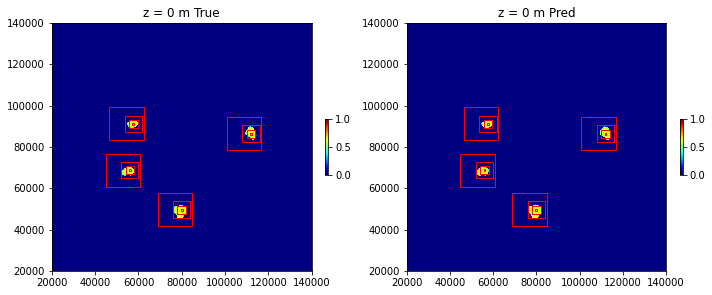

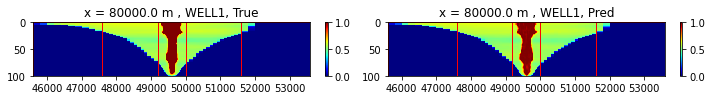

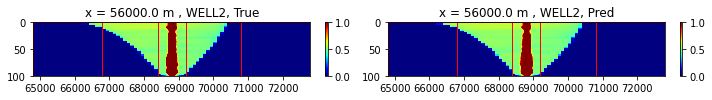

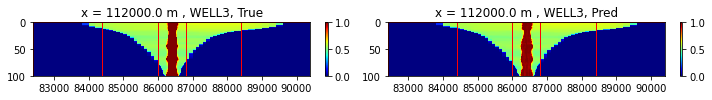

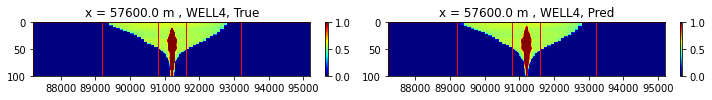

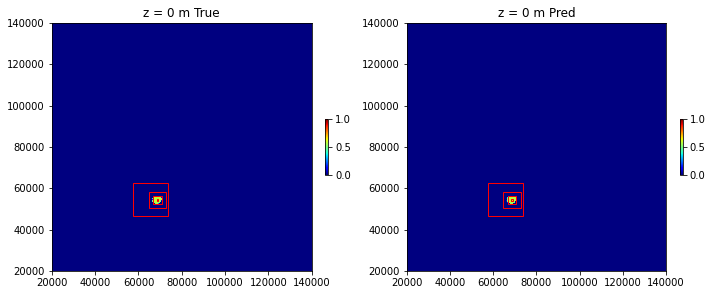

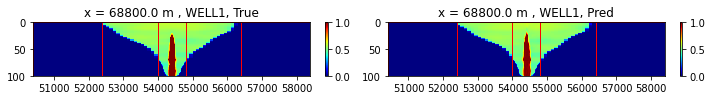

In [8]:
import time

it = iter(test_loader)
t1, t2, t3, t4 = [], [], [], []

for counter in range(2):
    with torch.no_grad():
        PRED, TRUE = {}, {}
        data = next(it)
        x, y, path = data['x'], data['y'], data['path']
        x, y = x[None,...].to(device), y[None,...]
        x[...,-1:] = NORMALIZER_DICT['input']['GLOBAL'].encode(x.to(device)[...,-1:])
        pred = NORMALIZER_DICT['output']['GLOBAL'].decode(MODEL_DICT['GLOBAL'](x)).cpu()
        PRED['GLOBAL'] = pred
        TRUE['GLOBAL'] = y
        slope, idx, well = path[0], path[1], path[2]

        meta_data = np.load(f'ECLIPSE/meta_data/{slope}_{idx}.npy', allow_pickle=True).tolist()
        WELL_LIST = meta_data[f'case_{idx}']['WELL_LIST']
        GRID_IDX_DICT = meta_data[f'case_{idx}']['GRID_IDX_DICT']

        for well in WELL_LIST:
            lgr_dict, true_dict = {}, {}

            data_LGR1 = torch.load(f'dataset/SG_LGR1/{slope}_{idx}_LGR1_{well}_SG.pt')
            I1, I2 = GRID_IDX_DICT[well]['LGR1']['I1']-1-15, GRID_IDX_DICT[well]['LGR1']['I2']+15
            J1, J2 = GRID_IDX_DICT[well]['LGR1']['J1']-1-15, GRID_IDX_DICT[well]['LGR1']['J2']+15
            coarse = np.repeat(PRED['GLOBAL'][0,...][:,I1:I2,J1:J2,:,:],5,axis=-2).permute(-1,1,2,3,0)[...,None]
            x_LGR1 = torch.cat((data_LGR1['input'][...,:-1],coarse),axis=-1)
            x_LGR1 = x_LGR1.permute(0,4,1,2,3,5).to(device)
            x_LGR1[...,-1:] = NORMALIZER_DICT['input']['LGR1'].encode(x_LGR1.to(device)[...,-1:])
            start = time.time()
            pred = MODEL_DICT['LGR1'](x_LGR1)
            end = time.time()
            t1.append(end-start)
            pred = pred.cpu()
            lgr_dict['LGR1'] = pred
            y = data_LGR1['output'][...,:1].permute(0,4,1,2,3,5)
            true_dict['LGR1'] = y

            data_LGR2 = torch.load(f'dataset/SG_LGR2/{slope}_{idx}_LGR2_{well}_SG.pt')
            coarse = np.repeat(lgr_dict['LGR1'][0,...],2,axis=-2).permute(-1,1,2,3,0)[...,None]
            x_LGR2 = torch.cat((data_LGR2['input'][...,:-1],coarse),axis=-1)
            x_LGR2 = x_LGR2.permute(0,4,1,2,3,5).to(device)
            start = time.time()
            pred = MODEL_DICT['LGR2'](x_LGR2)
            end = time.time()
            t2.append(end-start)
            pred = pred.cpu()
            lgr_dict['LGR2'] = pred
            y = data_LGR2['output'][...,:1].permute(0,4,1,2,3,5)
            true_dict['LGR2'] = y

            data_LGR3 = torch.load(f'dataset/SG_LGR3/{slope}_{idx}_LGR3_{well}_SG.pt')
            coarse = lgr_dict['LGR2'][0,...].permute(-1,1,2,3,0)[...,None]
            x_LGR3 = torch.cat((data_LGR3['input'][...,:-1],coarse),axis=-1)
            x_LGR3 = x_LGR3.permute(0,4,1,2,3,5).to(device)
            start = time.time()
            pred = MODEL_DICT['LGR3'](x_LGR3)
            end = time.time()
            t3.append(end-start)
            pred = pred.cpu()
            lgr_dict['LGR3'] = pred
            y = data_LGR3['output'][...,:1].permute(0,4,1,2,3,5)
            true_dict['LGR3'] = y

            data_LGR4 = torch.load(f'dataset/SG_LGR4/{slope}_{idx}_LGR4_{well}_SG.pt')
            coarse = lgr_dict['LGR3'][0,...].permute(-1,1,2,3,0)[...,None]
            x = data_LGR4['input']
            x_LGR4 = torch.cat((x[...,:-1],coarse),axis=-1)
            x_LGR4 = x_LGR4.permute(0,4,1,2,3,5).to(device)
            start = time.time()
            pred = MODEL_DICT['LGR4'](x_LGR4)
            end = time.time()
            t4.append(end-start)
            pred = pred.cpu()
            lgr_dict['LGR4'] = pred
            y = data_LGR4['output'][...,:1].permute(0,4,1,2,3,5)
            true_dict['LGR4'] = y

            PRED[well] = lgr_dict
            TRUE[well] = true_dict
            
        PRED['GLOBAL'] *= 0
        TRUE['GLOBAL'] *= 0
        
        plot_z_comparison()
        plot_x_comparison()
